****Importing the required libraries

In [ ]:
!pip install contractions

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Dropout, Embedding, Input,  BatchNormalization, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import nltk
from gensim.models import Word2Vec
from tensorflow.keras.utils import plot_model
from nltk.tokenize import TweetTokenizer
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import LearningRateScheduler
import contractions
import re
import pickle
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from sklearn.utils import class_weight
import os
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

print("complete")

complete


Importing the required nltk libraries

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

When working on kaggle, this unzip code is required, but if using in local computer, it may not be required

In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


****Dataset import

In [ ]:
dataset = load_dataset("SetFit/sst5")

Repo card metadata block was not found. Setting CardData to empty.


Print an example of the dataset, Here is the first 3 columns and the 3 corresponding labels

In [ ]:
print(type(dataset['train']))
print(dataset['train'][:3])

<class 'datasets.arrow_dataset.Dataset'>
{'text': ['a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films', 'apparently reassembled from the cutting-room floor of any given daytime soap .', "they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes ."], 'label': [4, 1, 1], 'label_text': ['very positive', 'negative', 'negative']}


Data preprocessing

importing lemmatization libraries

In [ ]:
lemmatizer = WordNetLemmatizer()
tweet_tokenizer = TweetTokenizer()
print("complete")

complete


In [ ]:
def fix_contractions(text):
    return contractions.fix(text)

This is the function to handle apostrophes error

In [ ]:
def fix_apostrophes(text):
    contractions = {
        "wo n't": "won't",
        "ca n't": "can't",
        "n't": "n't",
        " 's": "'s",
        " 't": "'t",
        " 're": "'re",
        " 've": "'ve",
        " 'll": "'ll",
        " 'd": "'d",
    }

    for key, value in contractions.items():
        text = text.replace(key, value)

    text = re.sub(r"wo n't", "won't", text)

    return text

for split in ['train', 'validation', 'test']:
    dataset[split] = dataset[split].map(lambda x: {"text": fix_apostrophes(x["text"])})

An example of after-fixed sentences

In [ ]:
for i in range(3):
    print(f"Text after Fix: {dataset['train'][i]['text']}")

Text after Fix: a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films
Text after Fix: apparently reassembled from the cutting-room floor of any given daytime soap .
Text after Fix: they presume their audience won't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .


Preprocess_text to do preprocessing data including
+) Tokenize and remove apostrophes
+) fix the splitting of apostrophes, removing the space before apostrophe
+) lemmatize words and remove non-aphabetical tokens

In [ ]:
def preprocess_text(text):
    tokens = tweet_tokenizer.tokenize(text.lower())
    tokens = [token.replace(" '", "") for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() or "-" in token]
    return tokens

Apply the prerprocessing techniques on the train, vlidation and test set
Here we give an example of the first 3 rows of the train set after the preprocessing techniques applied

In [ ]:
for split in ['train', 'validation', 'test']:
    dataset[split] = dataset[split].map(lambda x: {"text": preprocess_text(x["text"])}) if hasattr(dataset[split], 'map') else [{"text": preprocess_text(x["text"])} for x in dataset[split]]

for i in range(3):
    print(f"Sample {i + 1} preprocessed tokens: {dataset['train'][i]['text']}\n")

Sample 1 preprocessed tokens: ['a', 'stirring', 'funny', 'and', 'finally', 'transporting', 're-imagining', 'of', 'beauty', 'and', 'the', 'beast', 'and', 'horror', 'film']

Sample 2 preprocessed tokens: ['apparently', 'reassembled', 'from', 'the', 'cutting-room', 'floor', 'of', 'any', 'given', 'daytime', 'soap']

Sample 3 preprocessed tokens: ['they', 'presume', 'their', 'audience', 'sit', 'still', 'for', 'a', 'sociology', 'lesson', 'however', 'entertainingly', 'presented', 'so', 'they', 'trot', 'out', 'the', 'conventional', 'science-fiction', 'element', 'of', 'bug-eyed', 'monster', 'and', 'futuristic', 'woman', 'in', 'skimpy', 'clothes']



In [ ]:
train_texts = [' '.join(text) for text in dataset['train']['text']]
val_texts = [' '.join(text) for text in dataset['validation']['text']]
test_texts = [' '.join(text) for text in dataset['test']['text']]

Tokenization

In [ ]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~')
tokenizer.fit_on_texts(train_texts)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
tokenizer_path = '/kaggle/working/tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved successfully.")

Tokenizer saved successfully.


95th Percentile Sequence Length: 32


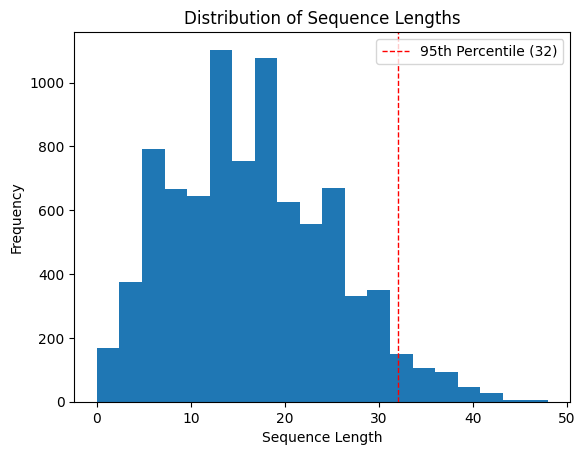

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
sequence_lengths = [len(seq) for seq in train_sequences]

#Calculate 95th Percentile
percentile_95 = np.percentile(sequence_lengths, 95)
max_length = int(percentile_95)

print(f"95th Percentile Sequence Length: {max_length}")
plt.hist(sequence_lengths, bins=20)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths")
plt.axvline(max_length, color='r', linestyle='dashed', linewidth=1, label=f'95th Percentile ({max_length})')
plt.legend()
plt.show()

We use the 95th percentile as the max_length value

In [ ]:
max_length = 32
train_sequences = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=max_length)
val_sequences = pad_sequences(tokenizer.texts_to_sequences(val_texts), maxlen=max_length)
test_sequences = pad_sequences(tokenizer.texts_to_sequences(test_texts), maxlen=max_length)

In [ ]:
embedding_dim = 300
custom_word2vec = Word2Vec(sentences=[text.split() for text in train_texts], vector_size=embedding_dim, window=5, min_count=2, workers=4)

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in custom_word2vec.wv:
        embedding_matrix[i] = custom_word2vec.wv[word]

print("Embedding Matrix shape:", embedding_matrix.shape)

Embedding Matrix shape: (13669, 300)


In [ ]:
embedding_matrix_path = '/kaggle/working/embedding_matrix.npy'
np.save(embedding_matrix_path, embedding_matrix)
print("Embedding matrix saved successfully.")

Embedding matrix saved successfully.


In [ ]:
embedding_matrix_path = '/kaggle/input/embedding_matrix.npy'
np.save(embedding_matrix_path, embedding_matrix)
print("Embedding matrix saved successfully.")

In [ ]:
tokenizer_path = '/kaggle/working/tokenizer.pkl'
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

print("Tokenizer loaded successfully.")


Tokenizer loaded successfully.


In [ ]:
embedding_matrix_path = '/kaggle/working/embedding_matrix.npy'
embedding_matrix = np.load(embedding_matrix_path)

print("Embedding matrix loaded successfully.")

Embedding matrix loaded successfully.


In [ ]:
# Convert labels to categorical
train_labels = np.array(dataset["train"]["label"])
val_labels = np.array(dataset["validation"]["label"])
test_labels = np.array(dataset["test"]["label"])
train_labels_categorical = tf.keras.utils.to_categorical(train_labels, num_classes=5)
val_labels_categorical = tf.keras.utils.to_categorical(val_labels, num_classes=5)
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=5)

In [ ]:
def get_class_weights(labels):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    return dict(zip(np.unique(labels), class_weights))


# Generate class weights
class_weights = get_class_weights(train_labels)
print("Class Weights:", class_weights)

Class Weights: {0: 1.5648351648351648, 1: 0.7704238052299369, 2: 1.0522167487684728, 3: 0.7359173126614987, 4: 1.3267080745341615}


In [ ]:
def create_cnn_model_simplified(vocab_size, embedding_dim, embedding_matrix, max_length, filters1, kernel_size1, dropout_rate, dense_units, learning_rate):
    # Xavier initialization
    xavier_initializer = tf.keras.initializers.GlorotNormal()  # Or use GlorotUniform()

    inputs = tf.keras.layers.Input(shape=(max_length,))

    # Using the embedding matrix, ensure it's not trainable
    x = tf.keras.layers.Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=False)(inputs)

    # First Conv1D layer
    x = tf.keras.layers.Conv1D(filters=filters1,
               kernel_size=kernel_size1,
               activation='relu',
               kernel_initializer=xavier_initializer,  # Xavier initialization
               )(x)


    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_units,
              activation='relu',
              kernel_initializer=xavier_initializer,  # Xavier initialization
              )(x)

    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)  # 5 output classes for the 5 sentiment categories

    model = tf.keras.models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
filters1 = 128
kernel_size1 = 3
dropout_rate = 0.5
dense_units = 128
learning_rate = 0.001
# Creating model
model = create_cnn_model_simplified(vocab_size=vocab_size,
                                  embedding_dim = embedding_dim,
                                  embedding_matrix=embedding_matrix,
                                  max_length = max_length,
                                  filters1 = filters1,
                                  kernel_size1 = kernel_size1,
                                  dropout_rate = dropout_rate,
                                  dense_units = dense_units,
                                  learning_rate = learning_rate)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 32, 300)        │     4,100,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 30, 128)        │       115,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,233,185 (16.15 MB)

 Trainable params: 132,485 (517.52 KB)

 Non-trainable params: 4,100,700 (15.64 MB)

In [ ]:
def create_cnn_model(filters, kernel_size, dropout_rate, dense_units, learning_rate):
    # Xavier initialization
    xavier_initializer = GlorotNormal()  # Or use GlorotUniform()

    inputs = Input(shape=(max_length,))

    # Using the embedding matrix, ensure it's not trainable
    x = Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=False)(inputs)

    # Apply Conv1D with Xavier initialization for weights
    x = Conv1D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               kernel_initializer=xavier_initializer,  # Xavier initialization
               kernel_regularizer=l2(0.01))(x)

    x = GlobalMaxPooling1D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units,
              activation='relu',
              kernel_initializer=xavier_initializer,  # Xavier initialization
              kernel_regularizer=l2(0.01))(x)

    x = Dropout(dropout_rate)(x)
    outputs = Dense(5, activation='softmax')(x)  # 5 output classes for the 5 sentiment categories

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# Create the model
model = create_cnn_model(filters, kernel_size, dropout_rate, dense_units, learning_rate)

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

NameError: name 'filters' is not defined

In [ ]:
class_weights = {0: 1.5648351648351648, 1: 0.7704238052299369, 2: 1.0522167487684728, 3: 0.7359173126614987, 4: 1.3267080745341615}

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy', choose accordingly
    patience=20,          # Number of epochs to wait before stopping if no improvement
    restore_best_weights=True
)

# Learning Rate Scheduler (Example, can be customized)
def lr_schedule(epoch, lr):
    if epoch > 10 and lr > 0.0001:
        return lr * 0.1
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss', # or 'val_accuracy'
    save_best_only=True,
    save_weights_only = True
)

In [ ]:
history = model.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,  # Use the class weights dictionary here
    callbacks=[early_stopping, lr_scheduler]
    #callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)
# Evaluate on the test set
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=5)
test_loss, test_accuracy = model.evaluate(test_sequences, test_labels_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1972 - loss: 1.6158 - val_accuracy: 0.2625 - val_loss: 1.6083 - learning_rate: 0.0010
Epoch 2/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2458 - loss: 1.5991 - val_accuracy: 0.2625 - val_loss: 1.6091 - learning_rate: 0.0010
Epoch 3/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2224 - loss: 1.6093 - val_accuracy: 0.2080 - val_loss: 1.6090 - learning_rate: 0.0010
Epoch 4/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2389 - loss: 1.6016 - val_accuracy: 0.1499 - val_loss: 1.6099 - learning_rate: 0.0010
Epoch 5/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1833 - loss: 1.6122 - val_accuracy: 0.2080 - val_loss: 1.6091 - learning_rate: 0.0010
Epoch 6/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2272 - loss: 1.6079 - val_accuracy: 0.1262 - val_loss: 1.6098 - learning_rate: 0.0010
Epoch 7/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1766 - loss: 1.

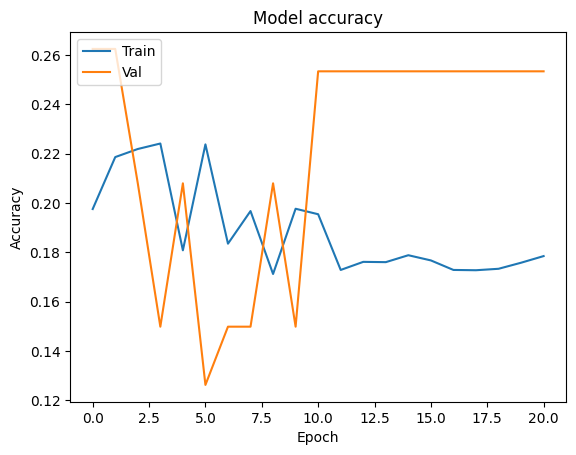

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


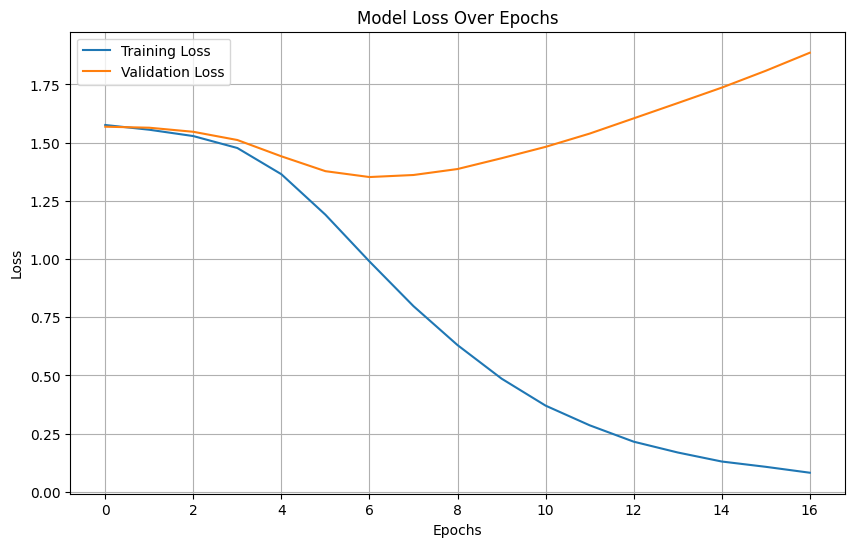

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


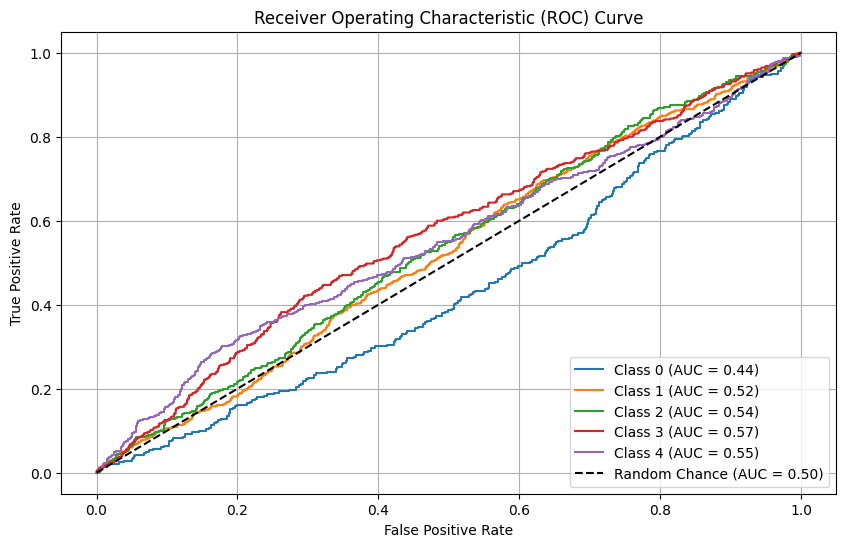

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Get predicted probabilities (for each class)
y_pred_prob = model.predict(test_sequences)

# Binarize the labels for multi-class ROC (convert labels into one-hot encoded format)
test_labels_binarized = label_binarize(test_labels, classes=[0, 1, 2, 3, 4])

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = 5

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 6))

# Plot each class ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot random chance line (diagonal)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')

# Final plot settings
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
best_filters1 = 160
best_kernel_size1 = 5
best_dropout_rate = 0.3
best_dense_units = 192
best_learning_rate = 0.0001

In [ ]:
def create_cnn_model_best_params(vocab_size, embedding_dim, max_length, filters1, kernel_size1, dropout_rate, dense_units, learning_rate):
    # Xavier initialization
    xavier_initializer = tf.keras.initializers.GlorotNormal()  # Or use GlorotUniform()

    inputs = tf.keras.layers.Input(shape=(max_length,))

    # Using random embedding layer
    x = tf.keras.layers.Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_length,
                  trainable=True)(inputs)

    # First Conv1D layer
    x = tf.keras.layers.Conv1D(filters=filters1,
               kernel_size=kernel_size1,
               activation='relu',
               kernel_initializer=xavier_initializer,  # Xavier initialization
               )(x)


    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_units,
              activation='relu',
              kernel_initializer=xavier_initializer,  # Xavier initialization
              )(x)

    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)  # 5 output classes for the 5 sentiment categories

    model = tf.keras.models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
best_model = create_cnn_model_best_params(vocab_size=vocab_size,
                                  embedding_dim = embedding_dim,
                                  max_length = max_length,
                                  filters1 = best_filters1,
                                  kernel_size1 = best_kernel_size1,
                                  dropout_rate = best_dropout_rate,
                                  dense_units = best_dense_units,
                                  learning_rate = best_learning_rate)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


# Train the model using your training data.
# Assuming train_sequences, train_labels_categorical, val_sequences, val_labels_categorical are defined
history = best_model.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=30,  # Or however many epochs you want
    batch_size=32,
    callbacks=[early_stopping]
)
# Evaluation
test_loss, test_accuracy = best_model.evaluate(test_sequences, test_labels_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2477 - loss: 1.5877 - val_accuracy: 0.2670 - val_loss: 1.5691
Epoch 2/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3125 - loss: 1.5491 - val_accuracy: 0.2925 - val_loss: 1.5645
Epoch 3/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3556 - loss: 1.5330 - val_accuracy: 0.2861 - val_loss: 1.5498
Epoch 4/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3938 - loss: 1.4810 - val_accuracy: 0.3697 - val_loss: 1.5029
Epoch 5/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4638 - loss: 1.3706 - val_accuracy: 0.3878 - val_loss: 1.4322
Epoch 6/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5513 - loss: 1.1763 - val_accuracy: 0.4033 - val_loss: 1.3853
Epoch 7/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6540 - loss: 0.9740 - val_accuracy: 0.3933 - val_loss: 1.3784
Epoch 8/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7445 - loss: 0.8025 - val_accuracy: 0.3978 - val_

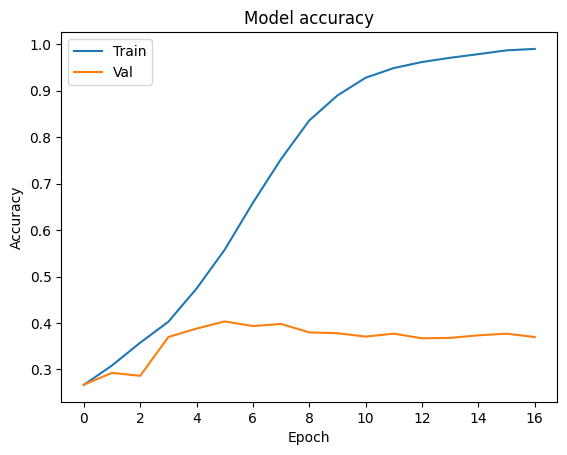

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Epoch 1/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2705 - loss: 1.5835 - val_accuracy: 0.2788 - val_loss: 1.5691
Epoch 2/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2938 - loss: 1.5558 - val_accuracy: 0.2816 - val_loss: 1.5620
Epoch 3/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3297 - loss: 1.5325 - val_accuracy: 0.3261 - val_loss: 1.5469
Epoch 4/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3907 - loss: 1.4891 - val_accuracy: 0.3433 - val_loss: 1.5128
Epoch 5/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4515 - loss: 1.3984 - val_accuracy: 0.3851 - val_loss: 1.4419
Epoch 6/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5420 - loss: 1.2167 - val_accuracy: 0.3942 - val_loss: 1.3756
Epoch 7/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6284 - loss: 1.0153 - val_accuracy: 0.4005 - val_loss: 1.3588
Epoch 8/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7366 - loss: 0.8212 - val_accu

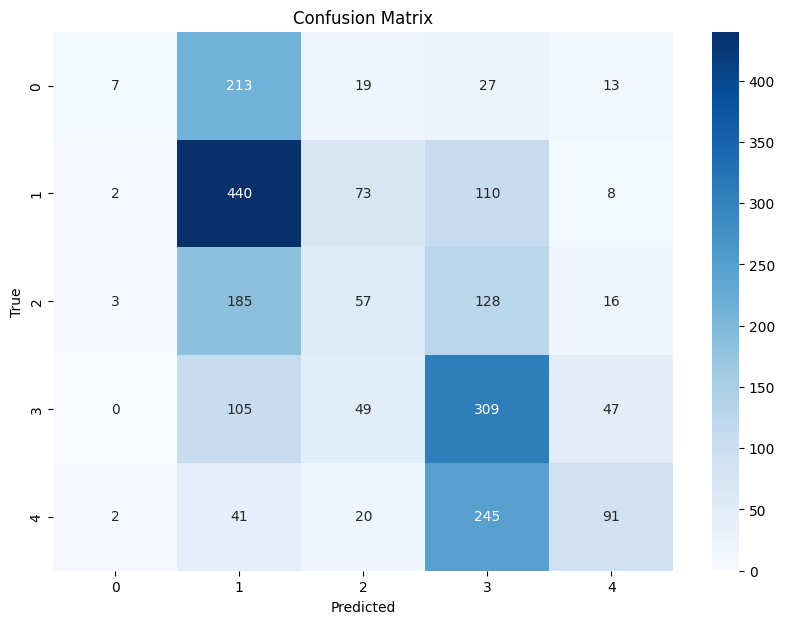

In [ ]:
best_filters1 = 160
best_kernel_size1 = 5
best_dropout_rate = 0.3
best_dense_units = 192
best_learning_rate = 0.0001

# define model using the same hypermodel from the hyperparameter tuning.
def create_cnn_model_best_params(vocab_size, embedding_dim, max_length, filters1, kernel_size1, dropout_rate, dense_units, learning_rate):
    # Xavier initialization
    xavier_initializer = tf.keras.initializers.GlorotNormal()  # Or use GlorotUniform()

    inputs = tf.keras.layers.Input(shape=(max_length,))

    # Using random embedding layer
    x = tf.keras.layers.Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_length,
                  trainable=True)(inputs)

    # First Conv1D layer
    x = tf.keras.layers.Conv1D(filters=filters1,
               kernel_size=kernel_size1,
               activation='relu',
               kernel_initializer=xavier_initializer,  # Xavier initialization
               )(x)


    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_units,
              activation='relu',
              kernel_initializer=xavier_initializer,  # Xavier initialization
              )(x)

    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)  # 5 output classes for the 5 sentiment categories

    model = tf.keras.models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
# Create your best model using the best hyper parameters
best_model = create_cnn_model_best_params(vocab_size=vocab_size,
                                  embedding_dim = embedding_dim,
                                  max_length = max_length,
                                  filters1 = best_filters1,
                                  kernel_size1 = best_kernel_size1,
                                  dropout_rate = best_dropout_rate,
                                  dense_units = best_dense_units,
                                  learning_rate = best_learning_rate)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train the model using your training data.
# Assuming train_sequences, train_labels_categorical, val_sequences, val_labels_categorical are defined
history = best_model.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=100,  # Or however many epochs you want
    batch_size=32,
    callbacks=[early_stopping]
)
# Evaluation
test_loss, test_accuracy = best_model.evaluate(test_sequences, test_labels_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict labels on the test set
test_predictions = best_model.predict(test_sequences)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Classification report
print(classification_report(test_labels, test_predictions_classes))

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
plot_model(best_model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)
print("Model visualization saved to model_plot.png")

Model visualization saved to model_plot.png


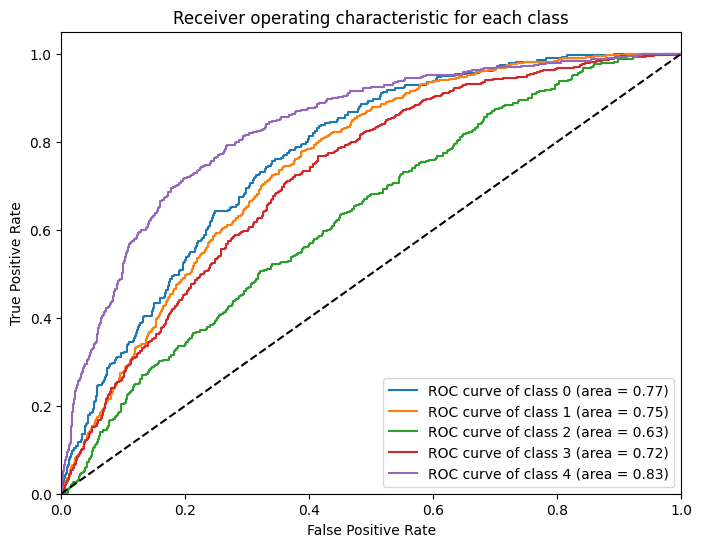

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ROC curve

# Binarize the labels using one-hot encoding.
test_labels_binarized = label_binarize(test_labels, classes=range(5))

plt.figure(figsize=(8,6))
# Initialize a dictionary to store the roc curve information.
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
for i in range(5):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--') # plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for each class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
best_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 32, 300)        │     4,100,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 28, 192)        │       288,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 192)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,280,741 (50.66 MB)

 Trainable params: 4,426,913 (16.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,853,828 (33.77 MB)

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_sequences, test_labels_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict labels on the test set
test_predictions = best_model.predict(test_sequences)
test_predictions_classes = np.argmax(test_predictions, axis=1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4048 - loss: 1.3324
Test Loss: 1.3270, Test Accuracy: 0.4090
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


This is the model using the best hyperparameter from the hyperparameter tuning process in later steps

We will evaluate the model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

#Best Hyperparameters:
best_filters1 = 192
best_kernel_size1 = 5
best_dropout_rate = 0.30000000000000004
best_dense_units = 192
best_learning_rate = 0.00025969686397759293

In [ ]:
# define model using the same hypermodel from the hyperparameter tuning.
def create_cnn_model_best_params(vocab_size, embedding_dim, max_length, filters1, kernel_size1, dropout_rate, dense_units, learning_rate):
    # Xavier initialization
    xavier_initializer = tf.keras.initializers.GlorotNormal()  # Or use GlorotUniform()

    inputs = tf.keras.layers.Input(shape=(max_length,))

    # Using random embedding layer
    x = tf.keras.layers.Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_length,
                  trainable=True)(inputs)

    # First Conv1D layer
    x = tf.keras.layers.Conv1D(filters=filters1,
               kernel_size=kernel_size1,
               activation='relu',
               kernel_initializer=xavier_initializer,  # Xavier initialization
               )(x)


    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_units,
              activation='relu',
              kernel_initializer=xavier_initializer,  # Xavier initialization
              )(x)

    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)  # 5 output classes for the 5 sentiment categories

    model = tf.keras.models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Create your best model using the best hyper parameters
best_model = create_cnn_model_best_params(vocab_size=vocab_size,
                                  embedding_dim = embedding_dim,
                                  max_length = max_length,
                                  filters1 = best_filters1,
                                  kernel_size1 = best_kernel_size1,
                                  dropout_rate = best_dropout_rate,
                                  dense_units = best_dense_units,
                                  learning_rate = best_learning_rate)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = best_model.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping]
)
# Evaluation
test_loss, test_accuracy = best_model.evaluate(test_sequences, test_labels_categorical)

# Predict labels on the test set
test_predictions = best_model.predict(test_sequences)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Calculate the metrics
test_precision = precision_score(test_labels, test_predictions_classes, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_predictions_classes, average='weighted', zero_division=0)
test_f1 = f1_score(test_labels, test_predictions_classes, average='weighted', zero_division=0)
test_accuracy_overall = accuracy_score(test_labels, test_predictions_classes)


# Print the metrics
print("Model       | Accuracy | Precision | Recall   | F1       |")
print("------------|----------|-----------|----------|----------|")
print(f"CNN         | {test_accuracy_overall:.4f}  | {test_precision:.4f}  | {test_recall:.4f}   | {test_f1:.4f}   |")

Epoch 1/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2740 - loss: 1.5764 - val_accuracy: 0.3170 - val_loss: 1.5579
Epoch 2/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3592 - loss: 1.5119 - val_accuracy: 0.3815 - val_loss: 1.4382
Epoch 3/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4916 - loss: 1.2580 - val_accuracy: 0.3996 - val_loss: 1.3533
Epoch 4/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6590 - loss: 0.8955 - val_accuracy: 0.3915 - val_loss: 1.4007
Epoch 5/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8476 - loss: 0.5491 - val_accuracy: 0.3715 - val_loss: 1.5473
Epoch 6/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9393 - loss: 0.2833 - val_accuracy: 0.3778 - val_loss: 1.7422
Epoch 7/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9693 - loss: 0.1571 - val_accuracy: 0.3906 - val_loss: 1.8975
Epoch 8/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9840 - loss: 0.0875 - val_accuracy: 0.

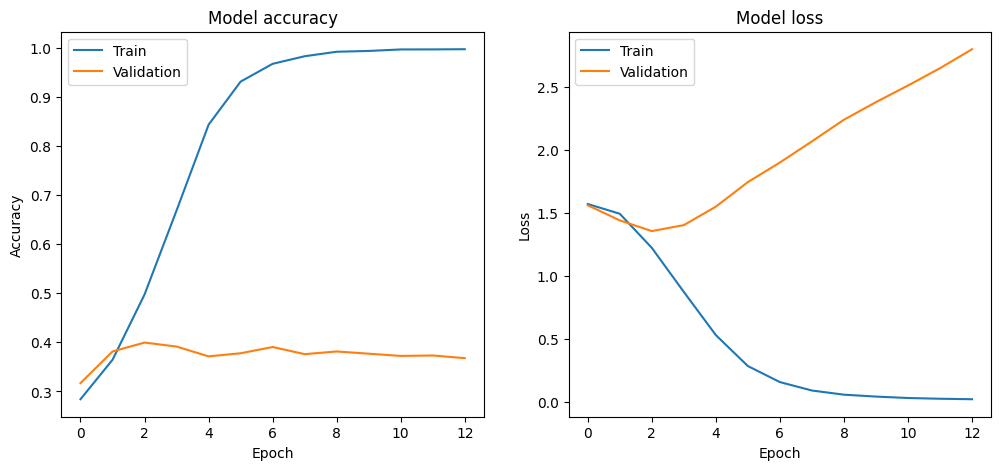

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Hyperparameter tuning**
In this part is the hyperparameter tuning process, we have applied two tuning the first one is to find the most optimal structure and the second is to find the best hyperparameter for the above model

In [ ]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


# Instantiate a tuner
tuner = kt.RandomSearch(
    hypermodel=hypermodel_builder,
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=10,  # Number of different hyperparameter combinations to try
    directory='tuning_dir',  # Directory to store tuner logs and models
    project_name='cnn_tuning',
    overwrite = True #overwrite if project exists.
)


# Mock Data (Replace with your actual data)
train_sequences = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=max_length)
train_labels_categorical = tf.keras.utils.to_categorical(train_labels, num_classes=5)
val_sequences = pad_sequences(tokenizer.texts_to_sequences(val_texts), maxlen=max_length)
val_labels_categorical = tf.keras.utils.to_categorical(val_labels, num_classes=5)
# Start the hyperparameter search
tuner.search(train_sequences,
             train_labels_categorical,
             epochs=10, # The number of training iterations to perform
             validation_data=(val_sequences, val_labels_categorical),
             callbacks=[early_stopping])

# Get the best model and its hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("\nBest Hyperparameters:")
print(best_hyperparameters.values)
# Evaluate the best model on test set

# Mock Test Data (Replace with your actual test data)
test_sequences = np.random.rand(50, max_length)
test_labels_categorical = tf.keras.utils.to_categorical(np.random.randint(0,5,50), num_classes = 5)


test_loss, test_accuracy = best_model.evaluate(test_sequences, test_labels_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

NameError: name 'hypermodel_builder' is not defined

This is the hyperparameter tuning process for the best model structure above

In [ ]:
def build_model(hp):
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True
    )

    inputs = Input(shape=(max_length,))
    x = embedding_layer(inputs)


    # Single Conv1D layer with tunable filters, kernel size
    x = Conv1D(
        filters=hp.Int("filters_0", min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice("kernel_size_0", values=[3, 5, 7]),
        activation="relu",
    )(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(hp.Float("dropout_rate_0", min_value=0.2, max_value=0.5, step=0.1))(x)

    # Dense layer with tunable units
    x = Dense(
        units=hp.Int("dense_units_0", min_value=128, max_value=256, step=64),
        activation="relu",
    )(x)
    x = Dropout(hp.Float("dense_dropout_rate_0", min_value=0.2, max_value=0.5, step=0.1))(x)

    # Output layer
    outputs = Dense(5, activation="softmax")(x)

    # Compile the model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )
    return model

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",  # Use validation accuracy as the optimization objective
    max_epochs=10,  # Each trial runs for up to 10 epochs
    factor=3,  # Halve resources every 3 epochs
    directory="hyperparameter_tuning",
    project_name="cnn_tuning_no_lstm"
)


# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)


# Start the hyperparameter search
tuner.search(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)


# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")


# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)


# Evaluate on the test set
test_loss, test_accuracy = best_model.evaluate(test_sequences, test_labels_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Trial 30 Complete [00h 00m 14s]
val_accuracy: 0.35876476764678955

Best val_accuracy So Far: 0.3805631101131439
Total elapsed time: 00h 04m 21s
Best Hyperparameters:
filters_0: 192
kernel_size_0: 5
dropout_rate_0: 0.30000000000000004
dense_units_0: 192
dense_dropout_rate_0: 0.30000000000000004
learning_rate: 0.00025969686397759293
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2712 - loss: 1.5972 - val_accuracy: 0.2534 - val_loss: 1.5940 - learning_rate: 2.5970e-04
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2678 - loss: 1.5824 - val_accuracy: 0.2988 - val_loss: 1.5736 - learning_rate: 2.5970e-04
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2809 - loss: 1.5740 - val_accuracy: 0.2670 - val_loss: 1.5813 - learning_rate: 2.5970e-04
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2977 - loss: 1.5684 - val_accuracy: 0.29

So the given best hyperparameters are
Best val_accuracy So Far: 0.3805631101131439
Total elapsed time: 00h 04m 21s
Best Hyperparameters:
filters_0: 192
kernel_size_0: 5
dropout_rate_0: 0.30000000000000004
dense_units_0: 192
dense_dropout_rate_0: 0.30000000000000004
learning_rate: 0.00025969686397759293
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014

In [ ]:
def build_final_model(hp):
    inputs = Input(shape=(max_length,))
    x = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False
    )(inputs)

    # Add Conv1D layers based on the best hyperparameters
    for i in range(best_hps.get('conv_layers')):
        filters = best_hps.get(f'filters_{i}')
        kernel_size = best_hps.get(f'kernel_size_{i}')
        dropout_rate = best_hps.get(f'dropout_rate_{i}')

        x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = Dropout(dropout_rate)(x)

    # Apply global max pooling
    x = GlobalMaxPooling1D()(x)

    # Dense layer with best hyperparameters
    x = Dense(units=best_hps.get('dense_units'), activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(best_hps.get('dense_dropout_rate'))(x)

    # Output layer
    outputs = Dense(5, activation='softmax')(x)

    # Build and compile model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )
    return model

In [ ]:
final_model = build_final_model(best_hps)

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = final_model.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=50,  # Train for 50 epochs as the final model
    batch_size=32,
    class_weight=class_weights_dict,  # Handle class imbalance
    callbacks=[early_stopping, lr_scheduler]  # Callbacks for training
)

test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=5)
test_loss, test_accuracy = final_model.evaluate(test_sequences, test_labels_categorical)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.4f}")
final_model.save("checkpoints/final_cnn_model.h5", save_format="h5")
shutil.make_archive(base_name="/kaggle/working/checkpoints", format="zip", root_dir="checkpoints")


In [ ]:
history = final_model.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=50,  # Train for 50 epochs, or adjust based on training progress
    batch_size=32,
    class_weight=class_weights,  # Adjusted class weights
    callbacks=[early_stopping, lr_scheduler]  # Use early stopping and learning rate scheduler
)

# Reevaluate after training
test_labels_categorical = tf.keras.utils.to_categorical(test_labels, num_classes=5)
test_loss, test_accuracy = final_model.evaluate(test_sequences, test_labels_categorical)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.4f}")

test_predictions = final_model.predict(test_sequences)

# Binarize the true labels (for multi-class classification)
test_labels_binarized = label_binarize(test_labels, classes=[0, 1, 2, 3, 4])

Model tuning

In [ ]:
def build_model_structure(hp):
    """
    Model tuning focuses on exploring structural variations in the model.
    This function allows experimentation with the number of layers and different configurations.
    """
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True
    )

    # Input layer
    inputs = Input(shape=(max_length,))
    x = embedding_layer(inputs)  # Output: (batch_size, max_length, embedding_dim)

    # Add multiple Conv1D layers based on tunable architecture
    for i in range(hp.Int("num_conv_layers", min_value=1, max_value=3)):  # Tune number of Conv1D layers (1 to 3)
        x = Conv1D(
            filters=hp.Choice(f"filters_{i}", values=[64, 128, 192, 256]),  # Tune filters for each layer
            kernel_size=hp.Choice(f"kernel_size_{i}", values=[3, 5, 7]),  # Tune kernel size for each layer
            activation="relu",
        )(x)
        # Apply pooling only in the last layer or conditionally
        if i == hp.Int("num_conv_layers", min_value=1, max_value=3) - 1:
            x = GlobalMaxPooling1D()(x)  # Only after all Conv1D layers

    # Dense layers
    x = Dropout(0.3)(x)
    x = Dense(
        units=hp.Int("dense_units_1", min_value=128, max_value=256, step=64),
        activation="relu",
    )(x)

    if hp.Boolean("use_second_dense_layer"):  # Optionally add a second dense layer
        x = Dense(
            units=hp.Int("dense_units_2", min_value=64, max_value=128, step=32),
            activation="relu",
        )(x)

    # Output layer
    outputs = Dense(5, activation="softmax")(x)

    # Compile the model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )
    return model



# Instantiate Keras Tuner for structural tuning
tuner = kt.Hyperband(
    build_model_structure,
    objective="val_accuracy",  # Use validation accuracy as the optimization objective
    max_epochs=10,  # Each trial runs for up to 10 epochs
    factor=3,  # Halve resources every 3 epochs
    directory="model_tuning",
    project_name="cnn_structure_tuning"
)


# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)


# Start the structural tuning search
tuner.search(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)


# Retrieve the best structural configuration
best_structure_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Model Structure Hyperparameters:")
for param in best_structure_hps.values.keys():
    print(f"{param}: {best_structure_hps.get(param)}")


# Build and train the best architecture
best_model_structure = tuner.hypermodel.build(best_structure_hps)
history = best_model_structure.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)


# Evaluate on the test set
test_loss, test_accuracy = best_model_structure.evaluate(test_sequences, test_labels_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Trial 24 Complete [00h 00m 10s]
val_accuracy: 0.37420526146888733

Best val_accuracy So Far: 0.3814713954925537
Total elapsed time: 00h 05m 20s
Best Model Structure Hyperparameters:
num_conv_layers: 1
filters_0: 128
kernel_size_0: 7
use_pooling_0: 1
dense_units_1: 192
use_second_dense_layer: True
learning_rate: 0.00012528693567478573
filters_1: 128
kernel_size_1: 7
dense_units_2: 96
filters_2: 64
kernel_size_2: 3
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2554 - loss: 1.5909 - val_accuracy: 0.2770 - val_loss: 1.5751 - learning_rate: 1.2529e-04
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2582 - loss: 1.5823 - val_accuracy: 0.2534 - val_loss: 1.5815 - learning_rate: 1.2529e-04
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2777 - loss: 1.5709 - val_accuracy: 0.2743 - val_loss: 1.5736 - learning_rate: 1.2529e-04
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
def build_model(hp):
    # Embedding layer with pre-trained weights
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True
    )

    inputs = Input(shape=(max_length,))
    x = embedding_layer(inputs)

    # Tunable Conv1D layer parameters
    x = Conv1D(
        filters=hp.Choice("filters_0", values=[64, 128, 192, 256]),
        kernel_size=hp.Choice("kernel_size_0", values=[3, 5, 7]),
        activation="relu",
    )(x)
    x = GlobalMaxPooling1D()(x)

    # Dropout layer
    x = Dropout(hp.Choice("dropout_rate_0", values=[0.2, 0.3, 0.4, 0.5]))(x)

    # First Dense layer
    x = Dense(
        units=hp.Choice("dense_units_0", values=[128, 192, 256]),
        activation="relu",
    )(x)
    x = Dropout(hp.Choice("dropout_rate_1", values=[0.2, 0.3, 0.4, 0.5]))(x)

    # Optional second Dense layer
    if hp.Boolean("use_second_dense_layer"):
        x = Dense(
            units=hp.Choice("dense_units_1", values=[64, 96, 128]),
            activation="relu",
        )(x)

    # Output layer
    outputs = Dense(5, activation="softmax")(x)

    # Compile the model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
        ),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )
    return model


# Hyperband Tuner for hyperparameter search
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",  # Optimize for validation accuracy
    max_epochs=10,  # Each trial runs for up to 10 epochs
    factor=3,  # Halve resources every 3 epochs
    directory="hyperparameter_tuning_best_model",
    project_name="cnn_best_model"
)

Reloading Tuner from hyperparameter_tuning_best_model/cnn_best_model/tuner0.json


In [ ]:
class_weights = {0: 1.5648351648351648, 1: 0.7704238052299369, 2: 1.0522167487684728, 3: 0.7359173126614987, 4: 1.3267080745341615}

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Start the hyperparameter search
tuner.search(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_sequences,
    train_labels_categorical,
    validation_data=(val_sequences, val_labels_categorical),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate on the test set
test_loss, test_accuracy = best_model.evaluate(test_sequences, test_labels_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Best Hyperparameters:
filters_0: 192
kernel_size_0: 5
dropout_rate_0: 0.3
dense_units_0: 128
dropout_rate_1: 0.2
use_second_dense_layer: False
learning_rate: 0.002813521144637759
dense_units_1: 64
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2442 - loss: 1.6476 - val_accuracy: 0.2561 - val_loss: 1.5832 - learning_rate: 0.0028
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2677 - loss: 1.5768 - val_accuracy: 0.2698 - val_loss: 1.6002 - learning_rate: 0.0028
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3127 - loss: 1.5364 - val_accuracy: 0.2716 - val_loss: 1.5790 - learning_rate: 0.0028
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4289 - loss: 1.3835 - val_accuracy: 0.3606 - val_loss: 1.5015 - learning_rate: 0.0028
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5782 - loss: 1.1626 - val_accuracy: 0.3479 - val_loss: 1.5225 - learning_rate: 0.0028
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6759 - loss: 1.0094 - val_accuracy: 0.3433 - val_loss: 1.6047 - learning_rate: 0.0028
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7708 - loss: 0.8714 - val_accurac

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3400 - loss: 1.5143
Test Loss: 1.5071, Test Accuracy: 0.3421
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.21      0.03      0.04       279
           1       0.42      0.51      0.46       633
           2       0.20      0.29      0.23       389
           3       0.35      0.38      0.36       510
           4       0.44      0.29      0.35       399

    accuracy                           0.34      2210
   macro avg       0.32      0.30      0.29      2210
weighted avg       0.34      0.34      0.33      2210



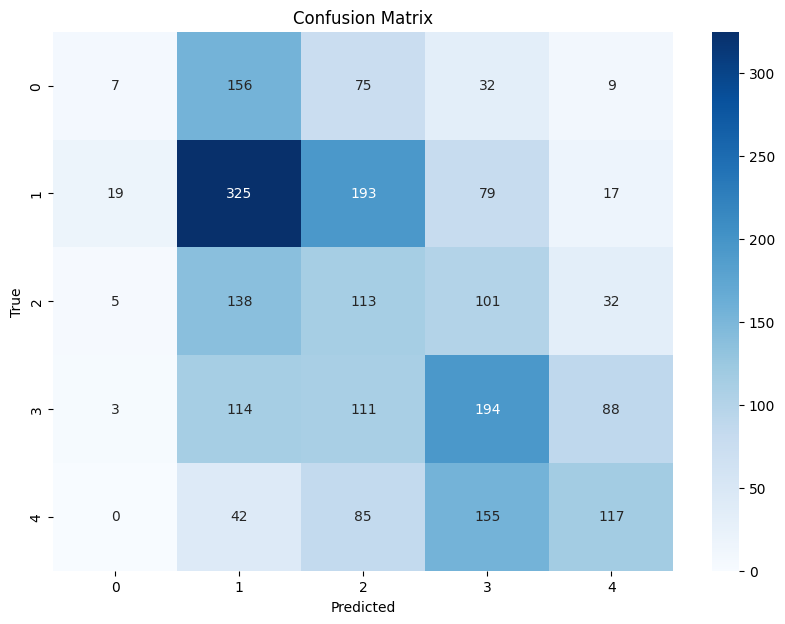

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_sequences, test_labels_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict labels on the test set
test_predictions = best_model.predict(test_sequences)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Classification report
print(classification_report(test_labels, test_predictions_classes))

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_predictions = best_model.predict(test_sequences)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Calculate the metrics
test_precision = precision_score(test_labels, test_predictions_classes, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_predictions_classes, average='weighted', zero_division=0)
test_f1 = f1_score(test_labels, test_predictions_classes, average='weighted', zero_division=0)
test_accuracy_overall = accuracy_score(test_labels, test_predictions_classes)


# Print the metrics
print("Model       | Accuracy | Precision | Recall   | F1       |")
print("------------|----------|-----------|----------|----------|")
print(f"CNN         | {test_accuracy_overall:.4f}  | {test_precision:.4f}  | {test_recall:.4f}   | {test_f1:.4f}   |")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model       | Accuracy | Precision | Recall   | F1       |
------------|----------|-----------|----------|----------|
CNN         | 0.3421  | 0.3407  | 0.3421   | 0.3265   |


In [ ]:
best_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 32, 300)        │     4,100,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 28, 192)        │       288,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 192)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,242,725 (50.52 MB)

 Trainable params: 4,414,241 (16.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,828,484 (33.68 MB)

In [ ]:
# Clear the previous tuning results (optional: only if you want a fresh start)
tuning_directory = "hyperparameter_tuning"
if os.path.exists(tuning_directory):
    import shutil
    shutil.rmtree(tuning_directory)